In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
import pyro

from src.data.preprocessing import detrend, ffnn_input_vector
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import greens_function, FFNN
from src.data.data_loader import load_uplift
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution

print(PROJECT_ROOT)
pyro.set_rng_seed(42)
%load_ext autoreload
%autoreload 2

/data/eigil/work/premis


In [2]:
def compute_error(trues, predicted):
    '''
    From course material
    '''
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    return corr, mae, rae, rmse

In [3]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
uplift = df.Up_kuaq.values

df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [ ]:
#  Gaussian Process models are :class:`~pyro.contrib.gp.util.Parameterized`
#     subclasses. So its parameters can be learned, set priors, or fixed by using
#     corresponding methods from :class:`~pyro.contrib.gp.util.Parameterized`. A typical
#     way to define a Gaussian Process model is

#         >>> X = torch.tensor([[1., 5, 3], [4, 3, 7]])
#         >>> y = torch.tensor([2., 1])
#         >>> kernel = gp.kernels.RBF(input_dim=3)
#         >>> kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#         >>> kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
#         >>> gpr = gp.models.GPRegression(X, y, kernel)

#     There are two ways to train a Gaussian Process model:

#     + Using an MCMC algorithm (in module :mod:`pyro.infer.mcmc`) on :meth:`model` to
#       get posterior samples for the Gaussian Process's parameters. For example:

#         >>> hmc_kernel = HMC(gpr.model)
#         >>> mcmc = MCMC(hmc_kernel, num_samples=10)
#         >>> mcmc.run()
#         >>> ls_name = "GPR/RBF/lengthscale"
#         >>> posterior_ls = mcmc.get_samples()[ls_name]

# X = torch.tensor([[1., 5, 3], [4, 3, 7]])
#         >>> y = torch.tensor([2., 1])
#         >>> kernel = gp.kernels.RBF(input_dim=3)
#         >>> kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#         >>> kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
#         >>> gpr = gp.models.GPRegression(X, y, kernel)

In [3]:
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
import pyro.contrib.gp as gp



In [4]:
X = torch.tensor([[1., 5, 3], [4, 3, 7]])
y = torch.tensor([2., 1])
kernel = gp.kernels.RBF(input_dim=3)
kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
gpr = gp.models.GPRegression(X, y, kernel)

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/pyro/contrib/gp/parameterized.py:106: UserWarning: The method `self.set_prior(variance, prior)` has been deprecated in favor of `self.variance = PyroSample(prior)`.
  warnings.warn(
/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/pyro/contrib/gp/parameterized.py:106: UserWarning: The method `self.set_prior(lengthscale, prior)` has been deprecated in favor of `self.lengthscale = PyroSample(prior)`.
  warnings.warn(


In [8]:
hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=10)
mcmc.run()

Sample: 100%|██████████| 20/20 [00:00, 90.68it/s, step size=1.33e+00, acc. prob=0.958]


In [10]:
mcmc.get_samples()["kernel.lengthscale"]

tensor([2.5066, 1.4579, 2.5907, 2.5561, 1.9718, 1.5864, 2.2822, 2.1248, 2.0350,
        2.4560])

In [39]:
def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X_train_tensor.view(-1,).numpy(), y_train_tensor.view(-1,).numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.tensor([[2., 3, 1]])  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        # plt.fill_between(Xtest.squeeze().numpy(),  # plot the two-sigma uncertainty about the mean
        #                  (mean - 2.0 * sd).numpy(),
        #                  (mean + 2.0 * sd).numpy(),
        #                  color='C0', alpha=0.3)
        plt.legend(["Data", "GP Posterior Mean"])
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-4, 4)

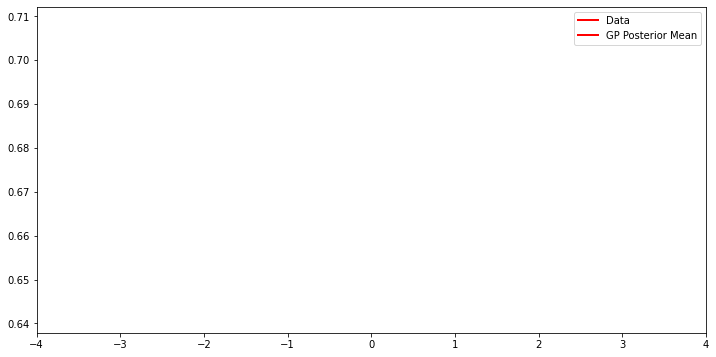

In [40]:
# Xnew = torch.tensor([[2., 3, 1], [4, 3, 7]]) 
plot(model=gpr, plot_observed_data=False, plot_predictions=True)

In [18]:
Xnew = torch.tensor([[2., 3, 1]])
f_loc, f_cov = gpr(Xnew, full_cov=True)


<bound method GPRegression.model of GPRegression(
  (kernel): RBF()
)>

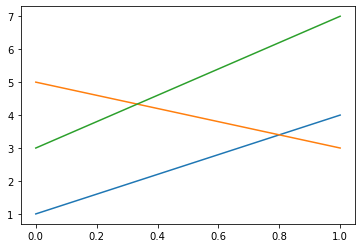

In [41]:
plt.plot(X)